In [1]:
%load_ext autoreload
%autoreload 2

In [3]:
import pandas as pd
from tqdm import tqdm
import time
import geopandas as gpd
from shapely.geometry import (LinearRing, LineString, MultiLineString,
                              MultiPoint, MultiPolygon, Point, Polygon)
from multiprocessing import Pool
import os
import re
import matplotlib.pyplot as plt

import mytools
# import importlib
# importlib.reload(mytools)

In [4]:
kongd = gpd.read_file('G:\\1-规划\\评估\\覆盖空洞\\输出20191230重新统计站点后\\覆盖空洞图层\\fugaikongd\\fugaikongd.shp',encoding='utf-8')

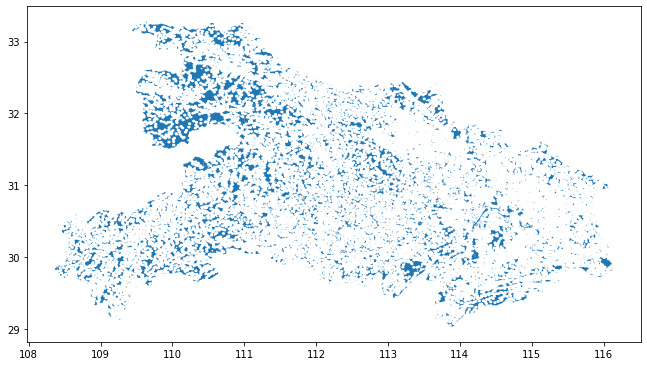

In [7]:
kongd.plot(figsize=(11,11))

# 20191107 工参数据图层

In [ ]:
#设置变量通用名
print('设置变量通用名')
id = '小区CGI(*)'
lon = 'RRU经度'
lat = 'RRU纬度'
changjing = '覆盖类别'
zhishi = ' 工作频段'
fw = '方位角'

In [ ]:
def gongcan():
    #导入数据
    print('导入数据')
    gongcan = pd.read_csv(open('g:/1-规划/工参/工参数据/ltejizhan20191212.csv',encoding = 'gbk'))
    gongcan['小区中文名'] = gongcan['小区中文名'].fillna('无')
    gongcan = gongcan.loc[~gongcan['小区中文名'].str.contains('W-')]
    gongcan = gongcan.loc[~gongcan['小区中文名'].str.contains('M-')]
    
    #过滤工参数据
    print('过滤工参数据')
    gongcan_loc = gongcan.loc[(gongcan[lon]>0) &  (gongcan[lat]>0) & (gongcan[fw]>0)]
    gongcan_loc[changjing] = gongcan_loc[changjing].apply(lambda x: np.NaN if str(x).isspace() else x)
    gongcan_loc.loc[gongcan_loc[changjing].isnull(),changjing]=2
    #添加覆盖距离
    print('添加覆盖距离')
    gongcan_loc_juli = mytools.gisn.changjing_distance(gongcan_loc,changjing,zhishi)
    gongcan_loc_juli_columns = gongcan_loc_juli[[id,lon,lat,fw,'distance','所属地区']]
    gongcan_loc_juli_columns['cgi'] = gongcan_loc_juli_columns['小区CGI(*)']
    gongcan_loc_juli_columns['distance'] = pd.to_numeric(gongcan_loc_juli_columns['distance'])
    gongcan_loc_juli_columns['juli_2'] = gongcan_loc_juli_columns['distance'] + gongcan_loc_juli_columns['distance']
    return gongcan_loc_juli_columns

In [ ]:
def ditu():
    city_tu = gpd.read_file('g:/1-规划/图层/湖北省地市-边界-边界/',encoding = 'gbk')
    city_tu = city_tu.to_crs({'init': 'epsg:4326'})
    city_tu = city_tu.replace('市', '', regex=True)
    city_tu['city'] = city_tu['kkk'] 
    return city_tu

In [ ]:
# city = '鄂州'
gongcan_loc_juli_columns = gongcan()
city_tu = ditu()
print(gongcan_loc_juli_columns.shape,'gongcan的行列数')
print(city_tu.shape,'地图的行列数')
gongcan_loc_juli_columns_1 = gongcan_loc_juli_columns.copy()
city_tu_shiyong = city_tu.copy()

In [ ]:
#做扇区
print('做扇区')
gongcan_s = mytools.gisn.add_sectors_df(gongcan_loc_juli_columns_1,coords=[lon, lat, 'd_height', fw, 'distance'], has_z=False, sec_col='geometry', shape_dict={'beam': 120, 'per_degree': 10})

In [ ]:
# print(city,'扇区完成，扇区的行列数',gongcan_s.shape,gongcan_s.head(1))
#将扇形一个地市合并成一个图
# print(city,'将扇形一个地市合并成一个图')
gongcan_city = gongcan_s.dissolve(by = '所属地区')
# print(city,'将扇形一个地市合并成一个图-ok',gongcan_city.area,gongcan_city.head(1))
#求与地市地图没有交集部分-覆盖空洞
# print(city,'求与地市地图没有交集部分')
city_tu_diff = gpd.overlay(city_tu_shiyong,gongcan_city,how='difference')
# print(city,'求与地市地图没有交集部分-ok',city_tu_diff.area,city_tu_diff.head(1))
#做弧扇区
# print(city,'做弧扇区')
gongcan_sh = tools_geo.add_sectors_min_max(gongcan_loc_juli_columns_1, coords=[lon, lat, 'd_height', fw, 'distance', 'juli_2'], has_z=False)
# print(city,'做弧扇区-ok',gongcan_sh.shape,gongcan_sh.head(1))
gongcan_s_area = tools_geo.add_area(gongcan_sh,column='扇形面积')
# print(city,'添加面积完成')

# print(city,'建立一个空的gpd')
#按照cgi分组
print(gongcan_s_area.columns)
data_t_groupby = gongcan_s_area.groupby(by = 'cgi')
nn = 0 
# print(city,'开始循环',gongcan_s_area.shape)
#创建一个空gpd
# res_conant = gpd.GeoDataFrame()
# for name_1 , data_t_1 in tqdm(data_t_groupby,ncols=70,desc = city ):
#     nn = nn +1 
#     res_t = gpd.overlay(data_t_1,city_tu_diff,how='intersection')
#     res_conant = res_conant.append(res_t)
#     # if nn%2 == 0:
#     #     print(city,nn)
#     #     print(city,'执行了',nn)

# print('循环结束')
# res_conant_res = tools_geo.add_area(res_conant, column='空洞面积')
# res_conant_res.to_csv(city+'.csv',encoding = 'gbk',index = False)
# print(city,'完成')

In [ ]:
gongcan_s.to_file('d:/扇形的区域.geojson',driver='GeoJSON',encoding='utf-8')

In [ ]:
gongcan_sh.to_file('d:/扇弧形的区域.geojson',driver='GeoJSON',,encoding='utf-8')

In [ ]:
gongcan_city.to_file('d:/扇形的区域合并.geojson',driver='GeoJSON',encoding='utf-8')

In [ ]:
city_tu_diff.to_file('d:/覆盖空洞全网.geojson',driver='GeoJSON',encoding='utf-8')

# 20191226评估覆盖空洞

## 找出全省覆盖空洞-->设置邮件及-->输出资源分配方案

### 1、找出覆盖空洞 - 空洞的用之前算的1万多
### 主要针对非空洞的进行计算，分为两个方面。1）由于站高原因导致的覆盖优先；2）由于周边建筑高度导致的覆盖优先

In [ ]:
gongcan = pd.read_csv(open('g:/1-规划/工参/工参数据/ltejizhan20191107.csv',encoding = 'gbk'))

In [ ]:
coverage_hole_cell = pd.read_csv(open('G:/1-规划/评估/覆盖空洞/3-跑出的空洞小区总表-各地市/有空洞的小区-小于0.5.csv',encoding='gbk')) 

In [ ]:
coverage_hole_cell.columns

In [ ]:
data_use = gongcan.merge(coverage_hole_cell,how='outer',left_on='小区CGI(*)',right_on='cgi',indicator=True)

In [ ]:
data_use_left = data_use.loc[data_use['_merge']=='left_only']

In [ ]:
data_use_left = data_use_left[['小区CGI(*)_x','所属地区_x','归属区县', '厂家名称', ' 工作频段', '网络制式(TDD/FDD)',
                               'RRU经度_x', 'RRU纬度_x', '天线挂高','方位角_x','机械下倾角', '电子下倾角']]

In [ ]:
changjing = gpd.read_file('g:/1-规划/图层/全省区域规划图层20180510/全省区域规划图层20180510/全省区域规划图层20180510.TAB',encoding='gbk')

In [ ]:
data_use_left = data_use_left.loc[(data_use_left['RRU经度_x']>0) & (data_use_left['RRU纬度_x']>0)& (data_use_left['方位角_x']>0)]

In [ ]:
data_use_left_p = tools_gis.add_points(data_use_left,'RRU经度_x','RRU纬度_x')

In [ ]:
res_lishi = gpd.sjoin(data_use_left_p,changjing,how='left')

In [ ]:
res_lishi['区域类型'] = res_lishi['区域类型'].replace({'3A景区':'乡镇','4A景区':'乡镇','5A景区':'乡镇','景区':'乡镇','热点':'乡镇'})

In [ ]:
res_lishi.loc[res_lishi['区域类型'].isna(),'区域类型']='农村'

In [ ]:
res_lishi.groupby('区域类型').count()

In [ ]:
data_use_left_use1 = tools_gis.changjing_distance(res_lishi,changjing='区域类型',zhishi=' 工作频段')

In [ ]:
f = file_name_paths(path='G:/1-规划/图层/湖北建筑/湖北建筑/湖北建筑/', find='.tab', case_sensitive=False)

In [ ]:
data_use_left_use1 = data_use_left_use1.drop(columns='geometry')

In [ ]:
data_use_left_use1_buff = tools_gis.add_sectors_df(data_use_left_use1,
    coords=['RRU经度_x', 'RRU纬度_x', 'd_height', '方位角_x', 'distance'],
    has_z=False,
    sec_col='geometry',
    shape_dict={'beam': 120, 'per_degree': 10})

In [ ]:
data_use_left_use1_buff = data_use_left_use1_buff.drop(columns='index_right')

In [ ]:
data_add = pd.DataFrame()
for name in f:
    t_tu = gpd.read_file(name)
    t_tu_1 = t_tu.to_crs({"init": "epsg:4326"})
    data_tu_res = gpd.sjoin(data_use_left_use1_buff,t_tu_1)
    data_tu_res_res = data_tu_res[['小区CGI(*)_x', '方位角_x', 'distance', '单位名称', '建筑物高度']]
    data_tu_res_res['平均值'] = data_tu_res_res['建筑物高度']
    data_group = data_tu_res_res.groupby(by = '小区CGI(*)_x').agg({'建筑物高度':'max','平均值':'mean'})
    data_group.reset_index(inplace = True)
    data_add = data_add.append(data_group)
    print(name,t_tu_1.shape,data_tu_res.shape,data_add.shape)

In [ ]:
data_add.to_csv('G:/1-规划/评估/覆盖空洞/输出20191226/lte142168个侠欧青周边站高.csv',encoding='gbk',index=False)

In [ ]:
hb_louyu = gpd.read_fail('g:/1-规划/图层/湖北建筑/湖北建筑/湖北建筑/')

# 20191230使用站点进行评估

## __小区和站点的对应关系 

In [ ]:
f = tools_other.file_name_paths(path='G:/1-规划/评估/竞对站点评估/2019年11月/1-基础数据/移动/计算每个地市的宏/', find=None, case_sensitive=False)

In [ ]:
duiying = pd.DataFrame()
for name in f:
    data = pd.read_excel(name,sheet_name='移动物理站',encoding='gbk')
    data_index = pd.read_excel(name,sheet_name='移动小区',encoding='gbk')
    data['对应小区'] = (data['FDD900_2'].map(str) + '/' + data['FDD1800_2'].map(str) + '/' + data['F_2'].map(str)
                          + '/' + data['D_2'].map(str) + '/'+ data['E_2'].map(str) + '/'+ data['A_2'].map(str) )
    data1 = (data.drop('对应小区', axis=1).join(data['对应小区'].str.split('/', expand=True).stack().reset_index(level=1, drop=True).rename('合并')))#列转行，一列分隔符转多行
    data2 = data1.loc[data1['合并']!='nan']
    linshi = data2.reset_index(drop=True)
    data3 = linshi.reset_index()
    data_index1 = data_index[['序号','小区中文名']]
    data_index1['序号'] = pd.to_numeric(data_index1['序号'])
    data3['合并'] =pd.to_numeric(data3['合并'])
    res_t = data3.merge(data_index1,how='left',left_on='合并',right_on='序号').sort_values('index').drop_duplicates('index')
    duiying = duiying.append(res_t)

In [ ]:
duiying.to_csv('G:/1-规划/评估/竞对站点评估/2019年11月/1-基础数据/移动/计算每个地市的宏/站点和小区对应关系.csv',encoding='gbk',index=False)

In [ ]:
duiying = pd.read_csv(open('G:/1-规划/评估/竞对站点评估/2019年11月/1-基础数据/移动/计算每个地市的宏/站点和小区对应关系.csv',encoding='gbk'))

In [ ]:
duiying.shape

## __站点汇总

In [ ]:
zhandian = pd.DataFrame()
for name in f:
    data = pd.read_excel(name,sheet_name='移动物理站',encoding='gbk')
    zhandian = zhandian.append(data)

In [ ]:
zhandian = zhandian.drop_duplicates('小区中文名')

In [ ]:
# zhandian.to_csv('G:/1-规划/评估/竞对站点评估/2019年11月/1-基础数据/移动/计算每个地市的宏/站点汇总.csv',encoding='gbk',index=False)
zhandian = pd.read_csv(open('G:/1-规划/评估/竞对站点评估/2019年11月/1-基础数据/移动/计算每个地市的宏/站点汇总.csv',encoding='gbk'))

In [ ]:
zhandian.shape

## __站点求最近三个站点

In [ ]:
zhandian = pd.read_csv(open('G:/1-规划/评估/竞对站点评估/2019年11月/1-基础数据/移动/计算每个地市的宏/站点汇总.csv',encoding='gbk'))

In [ ]:
zhandian.columns

In [ ]:
zhanzhi_zuijin = tools_gis.nearest_site(zhandian,
    id_name_column='小区中文名',
    lon='CellLongitude',
    lat='CellLatitude',
    num_min_results=3,
    Including_itself=False)

## __站点匹配场景_地市_区县

In [ ]:
guihua = gpd.read_file('G:/1-规划/图层/全省区域规划图层20180510/全省区域规划图层20180510/全省区域规划图层20180510.TAB')

In [ ]:
zhanzhi_zuijin_p = tools_gis.add_points(zhanzhi_zuijin,'CellLongitude','CellLatitude')

In [ ]:
zhanzhi_changjing = gpd.sjoin(guihua,zhanzhi_zuijin_p)

In [ ]:
zhanzhi_changjing1 = zhanzhi_changjing[['小区中文名','区域类型']] 

In [ ]:
zhanzhi_zuijin_changjing = zhanzhi_zuijin.merge(zhanzhi_changjing1,how='left',left_on='小区中文名',right_on='小区中文名',indicator=True)

In [ ]:
zhanzhi_zuijin_changjing.loc[zhanzhi_zuijin_changjing['_merge']=='left_only','区域类型']= '农村'

In [ ]:
zhanzhi_zuijin_changjing1 = zhanzhi_zuijin_changjing[[ '小区中文名', '网络制式(TDD/FDD)', 'CellLongitude',
       'CellLatitude','FDD900', 'FDD1800', 'F', 'D', 'E', 'A', 'minimum_index_1', 'minimum_index_2',
       'minimum_index_3', 'distance_1', 'distance_2', 'distance_3', 'mean','区域类型']]

In [ ]:
zhanzhi_zuijin_changjing2 = zhanzhi_zuijin_changjing1.reset_index(drop=True)
zhanzhi_zuijin_changjing3 = zhanzhi_zuijin_changjing2.reset_index()

In [ ]:
gongcan = pd.read_csv(open('g:/1-规划/工参/工参数据/ltejizhan20191212.csv',encoding='gbk'))

In [ ]:
gongcan_use = gongcan[['小区中文名', '所属地区','归属区县', '厂家名称']]

In [ ]:
zhanzhi_zuijin_changjing4 = zhanzhi_zuijin_changjing3.merge(gongcan_use,how='left',on='小区中文名')

In [ ]:
zhanzhi_zuijin_changjing5 = zhanzhi_zuijin_changjing4.drop_duplicates('index')

## __站点制作扇弧形求覆盖空洞

In [ ]:
hb_ditu = gpd.read_file('g:/1-规划/图层/湖北省地市-边界-边界/全省地市边界.TAB',encoding='gbk')

In [ ]:
zhanzhi_zuijin_changjing5.loc[zhanzhi_zuijin_changjing5['FDD900']>0,'zhishi']='FDD900'

zhanzhi_zuijin_changjing5['区域类型'] = zhanzhi_zuijin_changjing5['区域类型'].replace({'3A景区':'乡镇','4A景区':'乡镇','5A景区':'乡镇','景区':'乡镇','热点':'乡镇'})

zhanzhi_zuijin_changjing6 = tools_gis.changjing_distance(zhanzhi_zuijin_changjing5, '区域类型', 'zhishi')
zhanzhi_zuijin_changjing6.to_csv('G:/1-规划/评估/覆盖空洞/输出20191230重新统计站点后/计算后站址_间距_字段.csv',encoding='gbk',index=False)
zhanzhi_zuijin_changjing6 = pd.read_csv(open('G:/1-规划/评估/覆盖空洞/输出20191230重新统计站点后/计算后站址_间距_字段.csv',encoding='gbk'))

In [ ]:
zhan_use = zhanzhi_zuijin_changjing5[['所属地区', '区域类型', '小区中文名','CellLongitude', 'CellLatitude','distance']]

In [ ]:
data_buff = tools_gis.add_buffer_df(zhan_use,
    lon='CellLongitude',
    lat='CellLatitude',
    buff_col='distance')

In [ ]:
data_city = data_buff.dissolve(by = '所属地区')
hb_ditu_diff = gpd.overlay(hb_ditu,data_city,how='difference')

In [ ]:
hb_ditu_diff.plot(figsize=[13,13])

In [ ]:
# hb_ditu_diff.to_file('G:/1-规划/评估/覆盖空洞/输出20191230重新统计站点后/覆盖空洞图层/fugaikongd.she',encoding='utf-8')

In [ ]:
hb_ditu_diff = gpd.read_file('G:/1-规划/评估/覆盖空洞/输出20191230重新统计站点后/覆盖空洞图层/fugaikongd.she',encoding='utf-8')

In [ ]:
# zhan_use.to_csv('G:/1-规划/评估/覆盖空洞/输出20191230重新统计站点后/覆盖空洞图层/站址数据.csv',encoding='gbk',index=False)

In [ ]:
zhan_use = pd.read_csv(open('G:/1-规划/评估/覆盖空洞/输出20191230重新统计站点后/覆盖空洞图层/站址数据.csv',encoding='gbk'))

## __站点制作2倍扇弧形关联度

In [ ]:
zhan_use = pd.read_csv(open('G:/1-规划/评估/覆盖空洞/输出20191230重新统计站点后/覆盖空洞图层/站址数据.csv',encoding='gbk'))
zhan_use['distance_2倍'] = zhan_use['distance'] + zhan_use['distance']
zhan_use['fw'] = 0
zhan_use1=zhan_use.copy()
data_buff_2b = gpd.GeoDataFrame()
for city,data_t in zhan_use1.groupby('所属地区'):
    data_buff_t = tools_gis.add_sectors_min_max(
        data_t,coords=[ 'CellLongitude', 'CellLatitude', 'd_height', 'fw','distance', 'distance_2倍'],
        has_z=False,sec_col='geometry',shape_dict={'beam': 360, 'per_degree': 10})
    data_buff_t_mianji = tools_gis.add_area(data_buff_t,column='面积原')
    data_buff_2b = data_buff_2b.append(data_buff_t_mianji)
    print(city,'ok-------------')
data_buff_2b.to_csv('G:/1-规划/评估/覆盖空洞/输出20191230重新统计站点后/扇弧形图层/ok.csv',encoding='gbk')

In [ ]:
data = pd.read_csv(open('G:/1-规划/评估/覆盖空洞/输出20191230重新统计站点后/扇弧形图层/ok.csv',encoding = 'gbk'),nrows=10)

#                 -------------------使用py文件跑

## __站点覆盖能力最强的小区站高和下倾角

In [ ]:
duiying = pd.read_csv(open('G:/1-规划/评估/竞对站点评估/2019年11月/1-基础数据/移动/计算每个地市的宏/站点和小区对应关系.csv',encoding='gbk'))

In [ ]:
duiying.columns

In [ ]:
duiying_linshi = duiying.reset_index(drop = True)

In [ ]:
duiying_guanxi = duiying_linshi.drop(columns='index').reset_index()

In [ ]:
gongcan = pd.read_csv(open('g:/1-规划/工参/工参数据/ltejizhan20191212.csv',encoding='gbk'))

In [ ]:
gongcan.columns

In [ ]:
gongcan_use = gongcan[['小区中文名', '天线挂高','机械下倾角', '电子下倾角',' 工作频段']]

In [ ]:
duiying_guanxi.columns

In [ ]:
duiying_guanxi_merge = duiying_guanxi.merge(gongcan_use,how='left',left_on='小区中文名_x',right_on='小区中文名')

In [ ]:
duiying_use_1 = duiying_guanxi_merge.drop_duplicates('index')

In [ ]:
duiying_use_1['覆盖能力'] = duiying_use_1[' 工作频段'].replace({'FDD900':1,'FDD1800':2,'F':3,'D':4,'E':5,'A':6})

In [ ]:
duiying_use_sort = duiying_use_1.sort_values('覆盖能力')

In [ ]:
max_fw_hide = duiying_use_sort.groupby(by='小区中文名_x').head(1)

## __合并新算法站址，py跑出来的数据

In [ ]:
f = tools_other.file_name_paths(path='G:/1-规划/评估/覆盖空洞/输出20191230重新统计站点后/空洞站址新算法结果分地市/', find=None, case_sensitive=False)

In [ ]:
zhanzhi_mianji = pd.DataFrame()
for name in f:
    data_t = pd.read_csv(open(name,encoding='gbk'))
    zhanzhi_mianji = zhanzhi_mianji.append(data_t)

In [ ]:
zhanzhi_mianji.shape

## __周边建筑高度

In [ ]:
df_use_jianzhu = zhanzhi_zuijin_changjing6.copy()

In [ ]:
df_use_jianzhu_buff = tools_gis.add_buffer_df(df_use_jianzhu,lon='CellLongitude',lat='CellLatitude',buff_col='distance')

In [ ]:
f = tools_other.file_name_paths('G:/1-规划/图层/湖北建筑/湖北建筑/湖北建筑/',find='tab')

In [ ]:
sjoin_data = gpd.GeoDataFrame()
for name in f:
    tuceng_t = gpd.read_file(name,encoding = 'gbk')
    tuceng_t = tuceng_t.to_crs({'init': 'epsg:4326'})
    linshi_t = gpd.sjoin(df_use_jianzhu_buff,tuceng_t)
    linshi_t = linshi_t[[ '小区中文名','建筑物高度']]
    sjoin_data = sjoin_data.append(linshi_t)

# __清单整理-匹配以上数据

In [ ]:
df_use = zhanzhi_zuijin_changjing6.copy()

In [ ]:
df_use.columns

In [ ]:
df_use['是否空洞'] = (df_use['distance']-df_use['mean'])>0

In [ ]:
zhanzhi_mianji_linshi2 = zhanzhi_mianji[['小区中文名','空洞面积','面积原']]

In [ ]:
df_use_ls2 = df_use.reset_index(drop=True)

In [ ]:
df_use_ls3 = df_use_ls2.drop(columns='index').reset_index()

In [ ]:
df_use_ls3.drop_duplicates

In [ ]:
df_use_ls4 = df_use_ls3.merge(zhanzhi_mianji_linshi2,how='left',on='小区中文名').drop_duplicates('index')

In [ ]:
df_use_ls4['是否覆盖空洞_用新算法_是否空洞'] = df_use_ls4['空洞面积']/df_use_ls4['面积原']>0.5

In [ ]:
max_fw_hide_ls1 = max_fw_hide[['小区中文名','天线挂高','机械下倾角','电子下倾角',' 工作频段']]

In [ ]:
df_use_ls5 = df_use_ls4.merge(max_fw_hide_ls1,how='left',on='小区中文名').drop_duplicates('index')

In [ ]:
sjoin_data['建筑物高度2'] = sjoin_data['建筑物高度'] 
sjoin_data['建筑物高度3'] = sjoin_data['建筑物高度'] 

In [ ]:
sjoin_data_linshi = sjoin_data.groupby(by = '小区中文名').agg({'建筑物高度':'mean','建筑物高度2':'count','建筑物高度3':'max'})

In [ ]:
df_use_ls6 = df_use_ls5.merge(sjoin_data_linshi,how='left',on='小区中文名').drop_duplicates('index')

In [ ]:
df_use_ls6.to_csv('G:/1-规划/评估/覆盖空洞/输出20191230重新统计站点后/结果表.csv',encoding='gbk',index=False)

# 小区周边的投诉情况

In [ ]:
gongcan = pd.read_csv(open('g:/1-规划/工参/工参数据/ltejizhan20191212.csv',encoding='gbk'))

In [ ]:
tousu = pd.read_csv(open('G:/1-规划/评估/覆盖空洞/输出20191230重新统计站点后/投诉表/广义投诉CI匹配表-截至12月11日更新TO赵曼.csv',encoding='gbk'))

In [ ]:
gongcan_use_1 = gongcan.loc[(gongcan['RRU经度']>0) & (gongcan['RRU纬度']>0)]

In [ ]:
gongan_p = tools_gis.add_points(gongcan_use_1,lon='RRU经度',lat='RRU纬度')

In [ ]:
tousu.columns

In [ ]:
tousu_buff = tools_gis.add_buffer(tousu,'经度','纬度')

In [ ]:
tousu_buff['geometry'][0]

In [ ]:
res = gpd.sjoin(tousu_buff,gongan_p)

In [ ]:
res.columns

In [ ]:
res_use = res[[ '2019年9月投诉量','2019年10月投诉量', '2019年11月投诉量','小区中文名']]

In [ ]:
res_use

In [ ]:
res_use1 = res_use.groupby(by='小区中文名').agg({'2019年9月投诉量':'sum','2019年10月投诉量':'sum','2019年11月投诉量':'sum'})

In [ ]:
res_use1.to_csv('G:/1-规划/评估/覆盖空洞/输出20191230重新统计站点后/投诉表/res.csv',encoding='gbk')

# 课题是用-覆盖空洞图层

In [ ]:
gongcan = pd.read_csv(open('g:/1-规划/工参/工参数据/ltejizhan20191212.csv',encoding='gbk'))

In [ ]:
gongcan_use_1 = gongcan.loc[(gongcan['RRU经度']>0) & (gongcan['RRU纬度']>0) & (gongcan['方位角']>-1)]

In [ ]:
gongcan_use = gongcan_use_1.copy()
gongcan_use['小区中文名'] = gongcan_use['小区中文名'].fillna('无')

In [ ]:
gongcan_use = gongcan_use.loc[~gongcan_use['小区中文名'].str.contains('W-')]
gongcan_use = gongcan_use.loc[~gongcan_use['小区中文名'].str.contains('M-')]

In [ ]:
hb_dishi = mytools.gisn.maps('湖北')

In [ ]:
gongcan_use_2 = mytools.gisn.points_coverage_merge(gongcan_use_1)

In [ ]:
gongcan_use_3 = mytools.gisn.changjing_distance(gongcan_use_2,'区域类型',' 工作频段')

In [ ]:
gongcan_sq = mytools.gisn.add_sectors_df( gongcan_use_3,
    coords=['RRU经度', 'RRU纬度', 'd_height', '方位角', 'distance'],
    has_z=False,
    sec_col='geometry',
    shape_dict={'beam': 120, 'per_degree': 10})

In [ ]:
gongcan_sq.loc[gongcan_sq['所属地区'].isna(),['所属地区','方位角']]

In [ ]:
gongcan_sq_hebing = gongcan_sq.dissolve(by='所属地区')

In [ ]:
fugaikongd = gpd.overlay(hb_dishi,gongcan_sq_hebing,how='difference')

In [ ]:
gongcan_use_2 = tools_gis.points_coverage_merge(gongcan_use_1)

In [ ]:
gongcan_use_2

# 水系剔除

In [ ]:
mianzhuangshuixi = mytools.othern.file_name_paths(path='G:\\1-规划\\图层\\HB_场景\\',find='面状水系.tab')
shuiku = mytools.othern.file_name_paths(path='G:\\1-规划\\图层\\HB_场景\\',find='湖泊、水库.tab')

shuixi1 = gpd.read_file(mianzhuangshuixi[0],encoding='gbk')
shuixi2 = gpd.read_file(shuiku[0],encoding='gbk')
print('开始导入覆盖空洞')
kongd = gpd.read_file('G:\\1-规划\\评估\\覆盖空洞\\输出20191230重新统计站点后\\覆盖空洞图层\\fugaikongd\\fugaikongd.shp',encoding='utf-8')
print('导入覆盖空洞图层完成')

shuixi1['fenlei']='面状'
shuixi2['fenlei']='湖泊'

kongdong_new = gpd.overlay(kongd,shuixi2,how='difference')

shuixi1['type'] =  shuixi1.type

shuixi1_use = shuixi1.loc[shuixi1['type']=='Polygon'].append(shuixi1.loc[shuixi1['type']=='MultiPolygon'].explode())

shuixi1_use_area = mytools.gisn.add_area(shuixi1_use)

shuixi1_use_area_use = shuixi1_use_area.loc[shuixi1_use_area['面积']>100]

shuixi1_use_area_use = shuixi1_use_area_use.reset_index(drop=True)

shuixi1_use_area_use['geometry'] = shuixi1_use_area_use.buffer(0.00000001)

shuixi1_use_area_use.shape

# data_t = shuixi1_use_area_use.dissolve(by='fenlei')
# kongdong_new_t = gpd.overlay(kongdong_new,data_t,how='difference')

def myYield(df):
    y = 1000
    x = 0
    while x<236973:
        shuixi1_use_t = df.iloc[x:y,]
        yield shuixi1_use_t
        print('完成{cishu}。{cishu2}。。'.format(cishu=x,cishu2 = y))
        x = y 
        y = y + 1000

kongdong_new_t = kongdong_new.copy()
for data_t in myYield(shuixi1_use_area_use):
    data_t = data_t.dissolve(by='fenlei')
    kongdong_new_t = gpd.overlay(kongdong_new_t,data_t,how='difference')

In [ ]:
kongdong_new_t_r = gpd.read_file('G:/1-规划/报告类/2019年课题2个/寻找有价值覆盖空洞方法/基础数据/跑出的空洞小区总表-各地市/',encoding='utf-8')

# 竞对站点

In [ ]:
te_sit = pd.read_csv(open('g:/1-规划/评估/竞对站点评估/2019年11月/2-处理过程/csv/电信汇总.csv',encoding='gbk'))
un_sit = pd.read_csv(open('g:/1-规划/评估/竞对站点评估/2019年11月/2-处理过程/csv/联通汇总.csv',encoding='gbk'))

In [ ]:
te_site_use = mytools.gisn.points_coverage_merge(te_sit,lon='经度',lat='纬度')
un_site_use = mytools.gisn.points_coverage_merge(un_sit,lon='经度',lat='纬度')

In [ ]:
te_site_use['900-1800-2400'] = te_site_use['900-1800-2400'].replace('900M','FDD900M')
un_site_use['900-1800-2400'] = un_site_use['900-1800-2400'].replace('900M','FDD900M')

In [ ]:
te_site_dis = mytools.gisn.changjing_distance(te_site_use,'区域类型','900-1800-2400')
un_site_dis = mytools.gisn.changjing_distance(un_site_use,'区域类型','900-1800-2400')

In [ ]:
te_site_buffer = mytools.gisn.add_buffer_df(te_site_dis,'经度','纬度','distance')
un_site_buffer = mytools.gisn.add_buffer_df(un_site_dis,'经度','纬度','distance')

In [ ]:
te_site_buffer.columns

In [ ]:
te_site_buffer_dissolve = te_site_buffer.dissolve(by='地市')
un_site_buffer_dissolve = un_site_buffer.dissolve(by='地市')

In [ ]:
te_site_kongd = gpd.overlay(kongdong_new_t_r,te_site_buffer_dissolve)
un_site_kongd = gpd.overlay(kongdong_new_t_r,un_site_buffer_dissolve)

In [ ]:
te_kongd = te_site_kongd.explode()
un_kongd = un_site_kongd.explode()

In [ ]:
te_kongd_use = te_kongd[['geometry']]
un_kongd_use = un_kongd[['geometry']]

In [ ]:
te_kongd_use.to_file('e:/te',encoding=("utf-8"))
un_kongd_use.to_file('e:/un',encoding='utf-8')

In [3]:
te_kongd_use = gpd.read_file('G:/1-规划/报告类/2019年课题2个/寻找有价值覆盖空洞方法/基础数据/te_kongd/')
un_kongd_use = gpd.read_file('G:/1-规划/报告类/2019年课题2个/寻找有价值覆盖空洞方法/基础数据/un_kongd/')